<a href="https://colab.research.google.com/github/miller00315/ia_studies/blob/main/nlp_funcamental_in_tensor_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Funamentals in TensorFlow

NLP has the goal of derivin information out of natural language (could be text or speech).

Another common term for NLP problems is sequence to sequence problem (seq2seq)

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-784f4b93-126f-b9c0-5c89-f1f6683e910d)


## Get helper function

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-28 22:47:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-28 22:47:03 (71.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import a series of helper functions for teh notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir, calculate_results

## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

Se the orgin source here.

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2024-05-28 22:47:09--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.207, 142.251.183.207, 142.251.180.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2024-05-28 22:47:09 (109 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
unzip_data("nlp_getting_started.zip")

## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python Pandas.

In [6]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [8]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# ow many examples of each class?
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [10]:
# How many total samples?

len(train_df), len(test_df)

(7613, 3263)

In [11]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [12]:
# Let's viaulaize some random training examples

import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("example\ temp")

Target: 0 (not real disaster)
Text:
@GorpuaZikinak  and tongue out as she collapsed in the cum puddle her whole body covered.

example\ temp
Target: 0 (not real disaster)
Text:
@indiepopmom I CANT BREATHE MY LUNGS COLLAPSED

example\ temp
Target: 0 (not real disaster)
Text:
Zimbabwe is a country with a collapsed government ruled by a dictator while many live below the poverty line.

example\ temp
Target: 1 (real disaster)
Text:
@durrellb Prices here are insane. Our dollar has collapsed against the US and it's punishing us. Thanks for the info.

example\ temp
Target: 0 (not real disaster)
Text:
I just collapsed in my bed ugh I'm exhausted

example\ temp


### Split dat into trainig and validation datasets

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# Use train_test_split to split training dat into training and validation sets

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [15]:
# Check the lengths

len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [ ]:
len(train_df_shuffled)

7613

In [16]:
# Check the firt 10 sentences

train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build the model is to convert your txt to numbers.

The a few ways to do this, namely:

* Tokeninzation - direct mapping of token (a token could be a word or a character) to number

* Embeding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embeding can be learned)


### Text vectorization (tokenization)

In [17]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [18]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [19]:
# Use the default TextVectorization parameters

text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <oov>)
                                    standardize="lower_and_strip_punctuation", # how to handle punctuation
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # creat a group of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be, if None, it will adjust automatically
                                    pad_to_max_tokens=False) # pad sequences to the same length


In [20]:
# Find the average number of tokens (words) in the trainig tweets

round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [21]:
# Steup text vectorization variables

max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a tweeot does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=max_length,
                                    output_mode="int"
                                    )

In [22]:
text_vectorizer.adapt(train_sentences)

In [23]:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [24]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence} \n \nVectorized version:")

text_vectorizer([random_sentence])

Original text:
Sammy and todd always to the rescue may not be in uniform but still to the rescue lmao. Forever KFC fam. 
 
Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[8841,    7, 2650,  262,    5,    2,  389,  133,   34,   21,    4,
        3292,   30,   80,    5]])>

In [25]:
# Get the unique words in the vocabulary

words_in_vocab = text_vectorizer.get_vocabulary()

top_10_words = words_in_vocab[:10]

bottom_10_words = words_in_vocab[-10:]

print(f"Number of words in vocab: {len(words_in_vocab)}")
print(top_10_words)
print(bottom_10_words)

Number of words in vocab: 10000
['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']
['painthey', 'painful', 'paine', 'paging', 'pageshi', 'pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Creating a Embedding using an Embedding layer

To make our embedding, we're going to use TensorFlow's embeding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for exampl, a value of 100 would mean each token gets represented by a vector 100 long.
* `input_length` = length of sequnces being passed to the embedding layer.

In [26]:
from tensorflow.keras.layers import Embedding

In [27]:
embedding = Embedding(input_dim=max_vocab_length, # set input shape
                      output_dim=128, # output shape
                      embeddings_initializer="uniform", # default, intialize randomly
                      input_length=max_length # how long is each input
                      )

In [28]:
embedding

In [29]:
# Get a random sentence from teh tarining set

random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence} \
    \n\nEmbedded version:")

# Embed the random sentence

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
#USGS M 1.4 - 4km E of Interlaken California: Time2015-08-06 00:52:25 UTC2015-08-05 17:52:25 -07:00 at ep... http://t.co/zqrcptLrUM #SM     

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01636697, -0.01405703, -0.03756199, ...,  0.04349514,
         -0.032907  , -0.02320576],
        [-0.00693915,  0.03426461, -0.01833714, ...,  0.04437156,
         -0.03948905,  0.01359539],
        [-0.01537759, -0.01024324,  0.04404697, ...,  0.03492235,
          0.04057812, -0.00229375],
        ...,
        [ 0.0241408 ,  0.03049104,  0.04406604, ..., -0.00717366,
          0.02090086, -0.03383999],
        [ 0.02437088,  0.02813056, -0.03858282, ..., -0.00280961,
          0.04563762, -0.02292827],
        [-0.03353995,  0.00135516,  0.01736769, ...,  0.04655555,
         -0.01037078, -0.03737321]]], dtype=float32)>

In [30]:
# Check out a single sample token's embedding

sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.01636697, -0.01405703, -0.03756199, -0.00613047,  0.00766439,
         0.02890761, -0.02431258, -0.03983684, -0.02251066,  0.01238359,
         0.02446589, -0.00876174, -0.03945863,  0.03121896, -0.00320773,
         0.04305438,  0.04737249, -0.01296883,  0.03789448,  0.03030237,
        -0.01316673,  0.03208568, -0.04419701,  0.03276697,  0.03039583,
         0.03631986, -0.01503464, -0.03131682, -0.00653889,  0.03243371,
         0.04557706, -0.03877397,  0.03293839,  0.03241087, -0.02752004,
         0.00851177, -0.01450994, -0.04094936, -0.04779334,  0.04736649,
         0.02180037, -0.01186055, -0.02918702,  0.03868252,  0.04630287,
         0.03662261, -0.0149883 , -0.02388766, -0.00785365,  0.03173846,
         0.03198148, -0.03221078,  0.00409622, -0.03005198, -0.00104891,
        -0.02624422,  0.02173886, -0.00105823,  0.03302529,  0.04465704,
        -0.04401683,  0.00698687,  0.01760227,  0.02041339,  0.042399  ,
  

## Modelling a text datset (running a series of experiments)

Now we've got a way to turn our text sequnces into numbers it's time to strat building series of modelling experitments.

[Machine learnign map](https://scikit-learn.org/0.18/tutorial/machine_learning_map/index.html#)

### Model 0: Geting a baseline

As with all machine learning models, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> 🔑 **Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.'

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
# Create tokenization and modeling ppeline

In [32]:
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # Convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # mdoel the text
                  ])

In [33]:
# Fite the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [35]:
# Evaluate our baseline model

baseline_score =  model_0.score(val_sentences, val_labels)

In [36]:
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [37]:
# Make predictions

baseline_preds = model_0.predict(val_sentences)

baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [38]:
train_labels[:20]

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0])

### Cerating a evaluation funtcion for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and could easily be fixed with a function.

Let's create a function to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

In [39]:
# Function to evaluate accuracy, precision, recall, f1-score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [40]:
# Get baseline results

baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [41]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Model 1: A simple Feed-forward neural network

In [42]:
# Create a tensorboard callback

SAVE_DIR = 'model_logs'

In [58]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [59]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [60]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [62]:
model_1_history = model_1.fit(
    x=train_sentences,
    y=train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=[create_tensorboard_callback(SAVE_DIR, "model_1_dense")]
    )

Saving TensorBoard log files to: model_logs/model_1_dense/20240528-235227
Epoch 1/5
215/215 [==============================] - 4s 19ms/step - loss: 0.2007 - accuracy: 0.9294 - val_loss: 0.5003 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1721 - accuracy: 0.9415 - val_loss: 0.5306 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1497 - accuracy: 0.9476 - val_loss: 0.5474 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1316 - accuracy: 0.9568 - val_loss: 0.5790 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1163 - accuracy: 0.9615 - val_loss: 0.6110 - val_accuracy: 0.7782


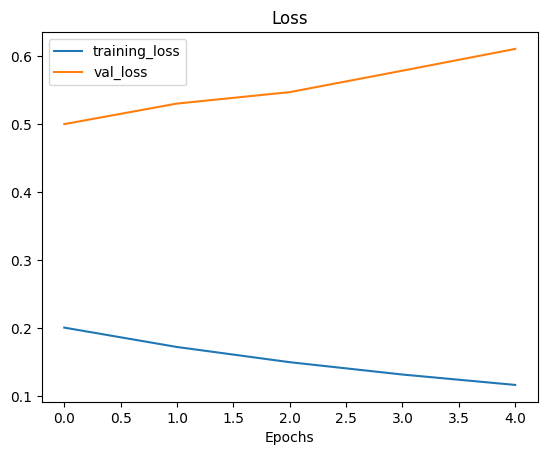

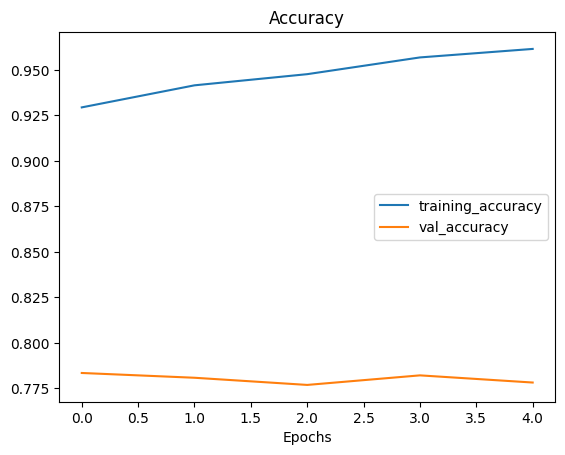

In [63]:
plot_loss_curves(model_1_history)

In [67]:
# check the results

model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.6110 - accuracy: 0.7782


[0.6110004782676697, 0.778215229511261]

In [65]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:20]

24/24 [==============================] - 1s 7ms/step


array([[4.7922114e-01],
       [7.4940151e-01],
       [9.9941742e-01],
       [7.8580379e-02],
       [9.5861815e-03],
       [9.8293936e-01],
       [8.8667774e-01],
       [9.9972516e-01],
       [9.9853313e-01],
       [5.1044136e-01],
       [9.9857245e-03],
       [8.4685808e-01],
       [8.7385662e-03],
       [2.1605450e-01],
       [4.2058120e-04],
       [1.0342668e-01],
       [7.7702096e-03],
       [7.2711851e-03],
       [1.4526099e-01],
       [8.2238358e-01]], dtype=float32)

In [66]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [76]:
# Convert model prerdiciton to label format
for pred in model_1_preds[:20]:
  if pred > 0.5:
    print("Positive")
  else:
    print("Negative")

Negative
Positive
Positive
Negative
Negative
Positive
Positive
Positive
Positive
Positive
Negative
Positive
Negative
Negative
Negative
Negative
Negative
Negative
Negative
Positive


## Visualising learned embedding

In [78]:
# Get teh vocanulary from the text vectorization layer

words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [79]:
max_vocab_length

10000

In [80]:
# Model 1 summary

model_1.summary()


Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [83]:
# Get the weight matrix of embedding layer

# (the se are teh numeriacal representation of each token in our training data)
embed_weights = model_1.get_layer("embedding").get_weights()[0]

print(embed_weights.shape)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has an incredible tool called projector: https://projector.tensorflow.org/

And Tensorflow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/tutorials/text/word_embeddings

In [85]:
embed_weights

array([[-3.7644275e-02, -3.4612384e-02, -7.7179917e-03, ...,
        -5.9109461e-03,  2.0801665e-02, -4.4287462e-03],
       [-4.7637038e-02,  1.6154282e-02, -1.4106596e-03, ...,
         3.7145514e-02, -3.9344616e-03, -3.7972338e-02],
       [-3.4115650e-02, -3.6986899e-02, -7.3975879e-03, ...,
        -1.5464366e-03,  3.3235960e-02,  9.7131664e-03],
       ...,
       [ 4.0986206e-02, -1.0221079e-04,  4.2291846e-02, ...,
        -5.4398403e-03, -4.1737009e-02,  1.7700303e-02],
       [ 4.3766532e-02,  7.0328275e-03,  2.0170307e-02, ...,
        -3.1688925e-02, -1.5768036e-02, -2.3616396e-02],
       [ 1.6244060e-01,  8.4819131e-02,  1.4552449e-01, ...,
        -7.3525071e-02, -1.3301471e-01,  1.2717751e-01]], dtype=float32)

In [86]:
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\temp")
  out_m.write(word + "\temp")
out_v.close()
out_m.close()
